## Bagging wth resnet 50, varying number of samples

In [1]:
import os
import sys
import glob
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import torchvision.models as models
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

SEED = 101
np.random.seed(SEED)
from torchvision import datasets, models, transforms

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Add the src directory for functions
src_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'src')
print(src_dir)
sys.path.append(src_dir)

# import my functions:
from WSI_pytorch_utils import*
from other_functions import*

fast_ai_dir = '/media/rene/Data/fastai/'
sys.path.append(fast_ai_dir)

torch.cuda.set_device(1)
print(torch.cuda.is_available())
print(torch.cuda.current_device())

/media/rene/Data/camelyon/src
True
1


In [3]:
ttv_split = np.load('/media/rene/Data/camelyon/other/ttv_split.p')
print(ttv_split)

{'normal_vaild_idx': array([ 95,  11,  81,  70,  63,  87,  75, 137,  40, 132,  63,  60, 110,   5, 140,  40,  49,  83, 111, 136,
       115, 157, 115,  59,  44,  72,  19, 126, 138,  76, 107,  87]), 'tumor_vaild_idx': array([  0, 105,  73,   8,  62,  36,  83,  99,  28,  63,   7,  10,  52,  56, 103,  38,  73,  52,  18,  71,
       103,  15])}


In [4]:
# get data
data_loc = '/media/rene/Data/camelyon_out/tiles_224_100t_all'
all_imgs = glob(data_loc+'/*')
img_names = [loc.rsplit('/', 1)[-1] for loc in all_imgs]

# load train valid split
ttv_split = np.load('/media/rene/Data/camelyon/other/ttv_split.p')
normal_valid = ttv_split['normal_vaild_idx']
tumor_valid = ttv_split['tumor_vaild_idx']
normal_train = list(range(1, 161))
normal_train = [num for num in normal_train if num not in normal_valid]
tumor_train = list(range(1, 111))
tumor_train = [num for num in tumor_train if num not in tumor_valid]

In [5]:
# get classes corresponding to each file
def get_label(name):
    if name.rsplit('_', 1)[-2][-5:]=='tumor':
        label = 'tumor'
    else: 
        label = 'normal'
    return label

classes = [get_label(name) for name in img_names]

# make csv
labels_df = pd.DataFrame(
    {'file_name': img_names,
     'label': classes
    })

# labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_labels.csv')

In [6]:
# get the validation indices from the big list
def is_validation(name, normal_valid, tumor_valid):
    normal_valid = [int(x) for x in normal_valid]
    tumor_valid = [int(x) for x in tumor_valid]
    num = int(name.split('_', 1)[1].split('_', 1)[0])
    
    if classes[idx] == 'normal':
        return num in normal_valid
    
    elif classes[idx] == 'tumor':
        return num in tumor_valid
    else:
        raise ValueError("tile isn't tumor or non tumor")

valid_idxs = []
for idx, name in enumerate(img_names):
    if is_validation(name, normal_valid, tumor_valid):
        valid_idxs.append(idx)
        
# with open('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_val_idxs.p', 'wb') as fp:
#     pickle.dump(valid_idxs, fp)

def make_validation_mask(data_df, normal_valid, tumor_valid):
    img_names = data_df['file_name'].tolist()
    valid_idxs = [is_validation(name, normal_valid, tumor_valid) for name in img_names]
    return valid_idxs

In [7]:
# get the indices of slides to use
def make_sample(labels_df, normal_train, tumor_train, downsample=2):
    normal_train_subset = random.sample(normal_train, int(len(normal_train)/int(downsample)))
    normal_train_subset = [int(x) for x in normal_train_subset]
    
    tumor_train_subset = random.sample(tumor_train, int(len(tumor_train)/int(downsample)))
    tumor_train_subset = [int(x) for x in tumor_train_subset]
    
    drop_rows = []
    for index, row in labels_df.iterrows():
        label = row['label']
        num = int(row['file_name'].split('_', 1)[1].split('_', 1)[0])
        
        if label == 'normal' and num not in normal_train_subset:
            drop_rows.append(index)
        elif label == 'tumor' and num not in tumor_train_subset:
            drop_rows.append(index)
    
    subset_labels_df = labels_df.drop(labels_df.index[drop_rows])
    return subset_labels_df

In [ ]:
models_arch = resnet50
models_name = 'resnet50'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'
# val_idxs = pickle.load( open( "/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_val_idxs.p", "rb" ) )

for i in tqdm(range(10)):
    # create the new csv and save it
    subset_labels_df = make_sample(labels_df, normal_train, tumor_train, downsample=1)
    subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv'
    
    # get the validation indices based on this
    val_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=64)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_full_wsi_'+str(i)) # train whole model

  0%|          | 0/10 [00:00<?, ?it/s]


epoch      trn_loss   val_loss   accuracy                      
    0      0.251628   0.230986   0.904331  



epoch      trn_loss   val_loss   accuracy                      
    0      0.204859   0.181028   0.927085  
    1      0.171781   0.159766   0.936005                      
    2      0.16793    0.153609   0.939367                      
    3      0.163332   0.148407   0.940271                      
    4      0.155354   0.138782   0.94777                       
    5      0.149487   0.136038   0.948287                      
    6      0.139184   0.13452    0.949192                      

 10%|█         | 1/10 [1:04:47<9:43:09, 3887.75s/it]

epoch      trn_loss   val_loss   accuracy                      
    0      0.250635   0.229239   0.904331  



epoch      trn_loss   val_loss   accuracy                      
    0      0.205928   0.178498   0.927085  
    1      0.180739   0.1568     0.937169                      
    2      0.165727   0.151327   0.940918                      
    3      0.169135   0.144584   0.943245                      
    4      0.14182    0.137435   0.948028                      
    5      0.139783   0.132605   0.948287                      
    6      0.14252    0.131039   0.949063                      

 20%|██        | 2/10 [2:04:31<8:18:06, 3735.83s/it]

epoch      trn_loss   val_loss   accuracy                      
    0      0.241574   0.223559   0.904848  



epoch      trn_loss   val_loss   accuracy                      
    0      0.204321   0.184216   0.922948  
    1      0.170985   0.158579   0.937557                      
    2      0.172508   0.155883   0.938203                      
 48%|████▊     | 565/1178 [03:42<04:01,  2.53it/s, loss=0.161]

In [ ]:
models_arch = resnet50
models_name = 'resnet50'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'
# val_idxs = pickle.load( open( "/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_val_idxs.p", "rb" ) )

for i in tqdm(range(10)):
    # create the new csv and save it
    subset_labels_df = make_sample(labels_df, normal_train, tumor_train, downsample=2)
    subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv'
    
    # get the validation indices based on this
    val_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=64)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_half_wsi_'+str(i)) # train whole model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/587 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   accuracy                    
    0      0.262329   0.223346   0.911861  



epoch      trn_loss   val_loss   accuracy                    
    0      0.208303   0.185835   0.926514  
    1      0.191932   0.160223   0.939209                    
    2      0.163955   0.153961   0.940674                    
    3      0.168058   0.14088    0.945801                    
    4      0.146847   0.137606   0.947998                    
    5      0.141507   0.129301   0.950684                    
    6      0.136285   0.129445   0.951904                    


 10%|█         | 1/10 [33:09<4:58:28, 1989.82s/it]

epoch      trn_loss   val_loss   accuracy                    
    0      0.267798   0.235747   0.901984  



epoch      trn_loss   val_loss   accuracy                    
    0      0.227203   0.188417   0.920722  
    1      0.182155   0.161996   0.93497                     
    2      0.184459   0.158538   0.93714                     
    3      0.158938   0.144103   0.944159                    
    4      0.145542   0.142144   0.946763                    
    5      0.132528   0.139232   0.946255                    
    6      0.14332    0.138325   0.947557                    


 20%|██        | 2/10 [1:05:43<4:22:55, 1971.91s/it]

epoch      trn_loss   val_loss   accuracy                    
    0      0.266833   0.222873   0.90734   



epoch      trn_loss   val_loss   accuracy                    
    0      0.221553   0.176262   0.928589  
    1      0.193404   0.145565   0.941307                    
    2      0.16546    0.14371    0.94276                     
    3      0.168801   0.133416   0.947847                    
    4      0.148051   0.12305    0.950391                    
    5      0.138405   0.1232     0.954388                    


 30%|███       | 3/10 [1:37:22<3:47:13, 1947.66s/it]

    6      0.140337   0.127227   0.951118  



epoch      trn_loss   val_loss   accuracy                    
    0      0.262889   0.218582   0.911615  



epoch      trn_loss   val_loss   accuracy                    
    0      0.2083     0.185892   0.923951  
    1      0.19502    0.15946    0.936012                    
 61%|██████    | 359/589 [02:25<01:33,  2.47it/s, loss=0.176]

In [ ]:
models_arch = resnet50
models_name = 'resnet50'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'
# val_idxs = pickle.load( open( "/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_val_idxs.p", "rb" ) )

for i in tqdm(range(10)):
    # create the new csv and save it
    subset_labels_df = make_sample(labels_df, normal_train, tumor_train, downsample=4)
    subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv'
    
    # get the validation indices based on this
    val_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=64)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_quarter_wsi_'+str(i)) # train whole model

In [8]:
models_arch = resnet50
models_name = 'resnet50'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'
# val_idxs = pickle.load( open( "/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_val_idxs.p", "rb" ) )

for i in tqdm(range(2, 3)):
    # create the new csv and save it
    subset_labels_df = make_sample(labels_df, normal_train, tumor_train, downsample=8)
    subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv'
    
    # get the validation indices based on this
    val_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=64)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_eighth_wsi_'+str(i)) # train whole model

  0%|          | 0/1 [00:00<?, ?it/s]


epoch      trn_loss   val_loss   accuracy                    
    0      0.306991   0.223781   0.90989   



epoch      trn_loss   val_loss   accuracy                    
    0      0.245368   0.158771   0.92967   
    1      0.181504   0.112273   0.953846                    
    2      0.174424   0.105541   0.958242                    
    3      0.145742   0.09217    0.958242                    
    4      0.130468   0.083142   0.969231                    
    5      0.118583   0.078321   0.969231                    
    6      0.116278   0.080027   0.971429                    

100%|██████████| 1/1 [07:29<00:00, 449.13s/it]

## Results

In [2]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
models_path = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
models_arch = [resnet50]*10

models_name = ['resnet50_full_wsi_'+str(i)for i in range (10)]
bagging_acc_full, acc_list_full, int_full= ensemble_acc_dir(models_arch, models_name, models_path, PATH, weights=None)

models_name = ['resnet50_half_wsi_'+str(i)for i in range (10)]
bagging_acc_half, acc_list_half, int_half = ensemble_acc_dir(models_arch, models_name, models_path, PATH, weights=None)

models_name = ['resnet50_quarter_wsi_'+str(i)for i in range (10)]
bagging_acc_quarter, acc_list_quarter, int_quarter = ensemble_acc_dir(models_arch, models_name, models_path, PATH, weights=None)

models_name = ['resnet50_eighth_wsi_'+str(i)for i in range (10)]
bagging_acc_eighth, acc_list_eighth, int_eighth = ensemble_acc_dir(models_arch, models_name, models_path, PATH, weights=None)

resnet50_full_wsi_0 :    0.9388023952095809
resnet50_full_wsi_1 :    0.938622754491018
resnet50_full_wsi_2 :    0.941377245508982
resnet50_full_wsi_3 :    0.9413173652694611
resnet50_full_wsi_4 :    0.9398203592814371
resnet50_full_wsi_5 :    0.94
resnet50_full_wsi_6 :    0.9421556886227545
resnet50_full_wsi_7 :    0.9397005988023952
resnet50_full_wsi_8 :    0.9393413173652695
resnet50_full_wsi_9 :    0.9388622754491018
0.9431736526946107
resnet50_half_wsi_0 :    0.9292814371257485
resnet50_half_wsi_1 :    0.9370059880239521
resnet50_half_wsi_2 :    0.9207185628742515
resnet50_half_wsi_3 :    0.9362275449101797
resnet50_half_wsi_4 :    0.931497005988024
resnet50_half_wsi_5 :    0.9321556886227544
resnet50_half_wsi_6 :    0.9020359281437126
resnet50_half_wsi_7 :    0.9304790419161677
resnet50_half_wsi_8 :    0.9283233532934132
resnet50_half_wsi_9 :    0.9300598802395209
0.9398203592814371
resnet50_quarter_wsi_0 :    0.9206586826347305
resnet50_quarter_wsi_1 :    0.9196407185628742
resne

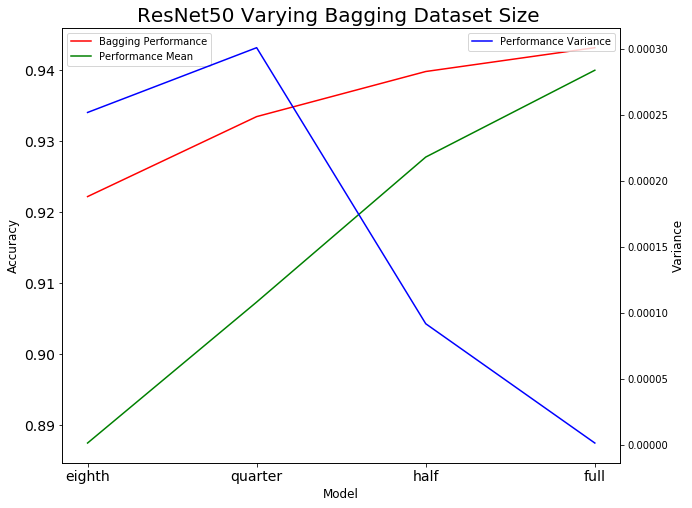

In [5]:
names = ['eighth', 'quarter', 'half', 'full']
data = [acc_list_eighth, acc_list_quarter, acc_list_half, acc_list_full]

mean_all = [np.mean(perf) for perf in data]
var_all = [np.var(perf) for perf in data]
perf_all = [bagging_acc_eighth, bagging_acc_quarter, bagging_acc_half, bagging_acc_full]

x = np.arange(len(names))
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

ax1.plot(x, perf_all, color='r')
ax1.plot(x, mean_all, color='g')

ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)

ax2.plot(x, var_all, color='b')
ax2.set_ylabel('Variance', fontsize=12)

ax1.legend(['Bagging Performance', 'Performance Mean'], loc='upper left')
ax2.legend(['Performance Variance'], loc='upper right')

plt.xticks(x, names)
ax1.tick_params(labelsize=14)

plt.title('ResNet50 Varying Bagging Dataset Size ', fontsize=20)
plt.show()

fig.savefig('/media/rene/Data/camelyon_out/figures/bagging_dataset_size.jpeg', bbox_inches='tight', pad_inches=0)

In [16]:
print(acc_list_full, bagging_acc_full, int_full)


0.9431736526946107 [0.9388023952095809, 0.938622754491018, 0.941377245508982, 0.9413173652694611, 0.9398203592814371, 0.94, 0.9421556886227545, 0.9397005988023952, 0.9393413173652695, 0.9388622754491018] [0.9388023952095809, 0.9407185628742515, 0.9425149700598803, 0.9424550898203593, 0.9432335329341317, 0.9425748502994012, 0.9437125748502994, 0.9435928143712575, 0.9431137724550899, 0.9431736526946107]
